# Distance between non-African and African haplotypes

If sweeps do displace archaic admixture, the swept haplotypes must originate from a a population without admxiture. That population can be either:

1. Earlier waves out of Africa
2. Later waves out of Africa.

Thre are three types of evidence we can use:

1. Do sweeps have a characteriestic distance to Africa.
2. Do all swepes have an african and do sweeps that do not have a different tmrca?
3. Are African populations included in sweeps low pi in the same regions?

The first question is most straightfowardly addressed by comparing, within each window of the chromosome, the haplotypes that are swept and those that are not. We can measure which African population each haplotype is closest to.

Measuring divervence to Africa is difficult: Population structure in Africa will inflate distance of a haplotype to African individuals if the subpopulation that the non-african is derived from is not sampled or has been lost. So simply comparing divergence to african populations of swept and non-swept haplotypes is potentially misleading.


In [1]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy
import pandas
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from GenomicWindows import window
import GenomicIntervals

numpy.random.seed(7)

Parallel computing:

In [2]:
# import ipyparallel
# from ipyparallel import depend, require

# # create client & view
# rc = ipyparallel.Client()
# dview = rc[:]
# bview = rc.load_balanced_view() # you can set block=True to have this apply globally

# # scatter 'id', so id=0,1,2 on engines 0,1,2
# dview.scatter('node_id', rc.ids, flatten=True)
# print("Engine IDs: ", dview['node_id'])
# # create a Reference to `id`. This will be a different value on each engine
# ref = ipyparallel.Reference('node_id')

# with dview.sync_imports(): # imports libs across dview
#     import re, os, sys, pickle
#     from pathlib import Path
#     import numpy
#     import pandas
#     from pandas import DataFrame
    
# dview.execute('numpy.random.seed(7)')

# def scatter_func(f):
#     dview.scatter(f.__name__, [f]*len(bview), flatten=True)    

# def getmem():
#     p = subprocess.Popen("echo $HOSTNAME", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     stdout, stderr = p.communicate()
#     return node_id, stdout.decode().strip(), resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024

# def print_mem():
#     for node_id, host_name, mem in  dview.apply(getmem).get():
#         print("{}{: >10}{: 10.2f} Mb". format(node_id, host_name, mem))

# def parallel_apply(grouped_df, fun):
#     return pandas.concat(dview.map_sync(fun, (group for name, group in grouped_df)))

Plotting setup:

In [3]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D 
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

Ignore deprecation warnings from mainly seaborn:

In [4]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

Analysis dirs:

In [5]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

Import variables global to the entire analysis:

In [6]:
import analysis_globals

Local code in the scripts dir on the cluster:

In [7]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Convenience functions

In [8]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

def bootstrap_se(sr, n=10000):
    means = list()
    for i in range(n):
        means.append(numpy.mean(sr.sample(frac=1, replace=True)))
    return numpy.std(means)

## Load meta data

In [9]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Load data for each individual

In [10]:
#all_male_indiv_dist = pandas.read_hdf(results_dir / 'all_male_indiv_dist.hdf')
sweep_data = (pandas.read_hdf(results_dir / 'sweep_data.hdf')
              .loc[lambda df: df.not_missing == True] # only include windows where enough individuals are called
             )
sweep_data.head()

,indiv_1,start,end,pop_1,region_label_1,region_id_1,region_1,mean_dist,mean_dist_af,mean_dist_to_africans,...,swept_af,not_missing,never_swept,never_swept_af,never_win_swept,never_win_swept_af,conserv_swept_group,conserv_swept_group_af,partial_sweep_win,partial_sweep_win_af
27,B_Australian-4,2700000,2800000,Australian,Oceania,4,Oceania,0.001057,0.001057,0.001719,...,False,True,True,True,True,True,no,no,False,False
28,B_Australian-4,2800000,2900000,Australian,Oceania,4,Oceania,0.000637,0.000628,0.001130,...,False,True,True,True,True,True,no,no,False,False
29,B_Australian-4,2900000,3000000,Australian,Oceania,4,Oceania,0.000380,0.000322,0.000844,...,False,True,True,True,False,False,no,no,False,False
30,B_Australian-4,3000000,3100000,Australian,Oceania,4,Oceania,0.001089,0.001089,0.001115,...,False,True,True,True,True,True,no,no,False,False
31,B_Australian-4,3100000,3200000,Australian,Oceania,4,Oceania,0.001220,0.001213,0.001545,...,False,True,True,True,True,True,no,no,False,False


## Mean distance to between African individuals for swept and non-swept windows

Mean distance *between* African individuals:

There are only a very small number of males in each population:

For this reason we use the pi based on all pseudohaploids:

## Mean pi across african populations for swept and non-swept windows

## Prepare data

In [11]:
pwdiff_store = pandas.HDFStore(str(results_dir / 'all_male_dist_twice.hdf'))

In [12]:
nonafr_afr_subset = pwdiff_store.select('df', '(region_label_1 != "Africa") & (region_label_2 == "Africa")')
nonafr_afr_subset.head()

,dist,dist_af,end,indiv_1,indiv_2,match,match_af,mismatch,mismatch_af,pop_1,pop_2,region_1,region_2,region_id_1,region_id_2,region_label_1,region_label_2,start,uncalled
8,NaN,NaN,100000,B_Australian-4,S_Biaka-1,274,274,0,0,Australian,Biaka,Oceania,Africa,4,0,Oceania,Africa,0,99726
9,NaN,NaN,100000,B_Australian-4,B_Ju_hoan_North-4,379,379,2,2,Australian,Ju_hoan_North,Oceania,Africa,4,0,Oceania,Africa,0,99619
17,NaN,NaN,100000,B_Australian-4,S_Ju_hoan_North-3,227,227,2,2,Australian,Ju_hoan_North,Oceania,Africa,4,0,Oceania,Africa,0,99771
22,NaN,NaN,100000,B_Australian-4,B_Yoruba-3,392,392,0,0,Australian,Yoruba,Oceania,Africa,4,0,Oceania,Africa,0,99608
23,NaN,NaN,100000,B_Australian-4,S_Biaka-2,257,257,0,0,Australian,Biaka,Oceania,Africa,4,0,Oceania,Africa,0,99743


In [13]:
nonafr_afr_subset.groupby('region_1')['indiv_1'].describe()

,count,freq,top,unique
region_1,,,,
Africa,0,None,None,0
WestEurasia,1749104,35696,S_Jordanian-1,49
SouthAsia,1106576,35696,S_Irula-2,31
CentralAsiaSiberia,392656,35696,S_Altaian-1,11
Oceania,571136,35696,S_Papuan-12,16
EastAsia,963792,35696,S_Ami-2,27
America,285568,35696,S_Karitiana-1,8


Merge data:

In [14]:
merged_data = (nonafr_afr_subset
#            .merge(mean_afr_pwdist, on=['start', 'end'], how='left')
#            .merge(mean_afr_pi, on=['start', 'end'], how='left')
           .merge(sweep_data[['indiv_1', 'start', 
                              'swept', 'swept_af', # 'surely_not_swept', #'swept_in_region', 
                              'never_swept',  'never_swept_af', 
                              'partial_sweep_win', 'partial_sweep_win_af',
                              'never_win_swept', 'never_win_swept_af',
                              'conserv_swept_group', 'conserv_swept_group_af',
                              'mean_dist_to_africans', 'mean_dist_to_africans_af']], 
                  on=['indiv_1', 'start'], how='left')
#            .assign(afr_dist_norm_afr_pwdist = lambda df: df.mean_dist_to_africans / df.mean_afr_pwdist,
#                    afr_dist_norm_afr_pi = lambda df: df.mean_dist_to_africans / df.mean_afr_pi)
          )

## Mean distance between non-Africans and Africans for swept and non-swept windows

> To test this hypothesis, we computed the mean distance of non-African swept and non-swept haplotypes to African haplotypes using the same subset of windows used in Subfigure 4.  We find that swept haplotypes show a reduced mean distance to Africans (Subfigure 5), although this is only significant CentralAsiaSiberia: 2.8% (paired t-test p-value corrected for multiple testing: 0.005), Oceania: 2.7% (p-value: 0.001), and  EastAsia: 2.9% (p-value: 0.001). This is not evidence that swept individuals carrying the swept haplotypes left Africa later, since population structure in Africa and representation of populations in our data set, may affect mean distances to Africa. However, it does show that the population or populations that contributed the swept haplotypes had a distinct genealogical relationship to Africa. 


              start           end  mean_afr_dist
swept                                           
False  7.353163e+07  7.363163e+07       0.000589
True   7.353163e+07  7.363163e+07       0.000579

449 100kb chromosome windows
paired t-test pvalue: 0.0230858510016
mean reduction of swept: 0.0220157780427


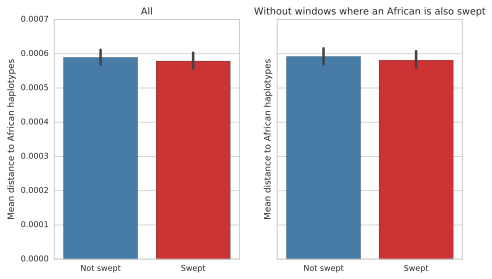

In [15]:
plot_df = (merged_data
      .loc[lambda df: (df.partial_sweep_win == True) & (df.conserv_swept_group != 'ambig')]
      .groupby(['start', 'end', 'swept'])['mean_dist_to_africans']
      .mean()
      .to_frame('mean_afr_dist')
      .reset_index()
      # removing 'ambig' creates windows that does not have both swept and non-swept
      # so we need to filter to get only windows that include both calls:
      .groupby(['start']).filter(lambda df: set(df['swept']) == set([False, True]))
       )

print(plot_df.groupby('swept').mean())
swept = plot_df.sort_values(by='start').loc[lambda df: df['swept']==True, 'mean_afr_dist']
non_swept = plot_df.sort_values(by='start').loc[lambda df: df['swept']==False, 'mean_afr_dist']
pval = scipy.stats.ttest_rel(swept, non_swept, axis=0, nan_policy='propagate').pvalue
reduction = (non_swept.values-swept.values)/non_swept.values
print()
print(len(swept), '100kb chromosome windows')
print('paired t-test pvalue:', pval)
print('mean reduction of swept:', numpy.mean(reduction))

windows_without_swept_afr = (sweep_data
                             .groupby(['start'])
                             .filter(lambda df: ((df.swept == True) & (df.region_1 == 'Africa')).sum() == 0)
                             .loc[:, ['start', 'end']]
                             .drop_duplicates()
                            )

with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.0):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), sharey=True)

            g1 = sns.barplot(x="swept", y="mean_afr_dist", 
                             data=plot_df, 
                             ax=ax1, n_boot=1000)
#             ax1.set_title('All data used when evaluating\npairwise differences')
            ax1.set_title('All')
            ax1.set_ylabel('Mean distance to African haplotypes')
            ax1.set_xlabel('')
            ax1.set_xticklabels(['Not swept', 'Swept'])
            
#             ax1.set_xticklabels(['All data used when evaluating\npairwise differences', 'Admixture segments ignored\nwhen evaluating pairwise distances'])


            
            g2 = sns.barplot(x="swept", y="mean_afr_dist", 
                             data=plot_df.merge(windows_without_swept_afr, on=['start', 'end']),
                             ax=ax2, n_boot=1000)
            ax2.set_title('Without windows where an African is also swept')
            ax2.set_ylabel('Mean distance to African haplotypes')
            ax2.set_xlabel('')
            ax2.set_xticklabels(['Not swept', 'Swept'])
            
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'dist_to_afr.pdf' ))
            plt.savefig(str(figures_dir / 'dist_to_afr.png' ))

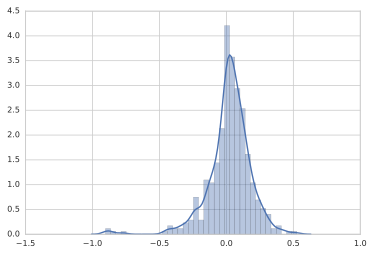

In [16]:
g = sns.distplot(reduction)

All:
WestEurasia          pvalue: 0.37       corrected pvalue: 2.2        mean reduction: 0.01      
SouthAsia            pvalue: 0.0063     corrected pvalue: 0.038      mean reduction: 0.028     
CentralAsiaSiberia   pvalue: 0.0014     corrected pvalue: 0.0086     mean reduction: 0.027     
Oceania              pvalue: 1.9e-05    corrected pvalue: 0.00012    mean reduction: 0.03      
EastAsia             pvalue: 0.00024    corrected pvalue: 0.0015     mean reduction: 0.027     
America              pvalue: 0.16       corrected pvalue: 0.97       mean reduction: 0.019     

Without windows where an African is also swept:
WestEurasia          pvalue: 0.38       corrected pvalue: 2.3        mean reduction: 0.0098    
SouthAsia            pvalue: 0.009      corrected pvalue: 0.054      mean reduction: 0.028     
CentralAsiaSiberia   pvalue: 0.0013     corrected pvalue: 0.0078     mean reduction: 0.029     
Oceania              pvalue: 3.4e-05    corrected pvalue: 0.00021    mean reductio

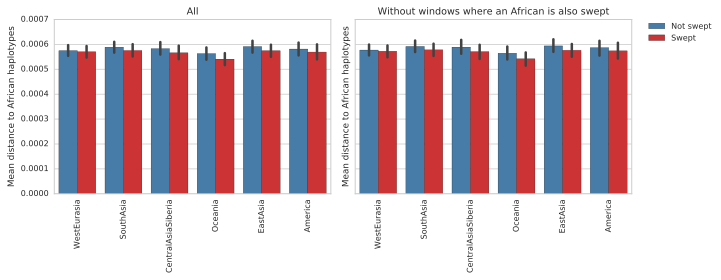

In [17]:
plot_df = (merged_data
      .loc[lambda df: (df.partial_sweep_win == True) & (df.conserv_swept_group != 'ambig')]
      .groupby(['start', 'end', 'swept', 'region_1'])['mean_dist_to_africans']
      .mean()
      .to_frame('mean_afr_dist')
      .reset_index()
      # removing 'ambig' creates windows that does not have both swept and non-swept
      # so we need to filter to get only windows that include both calls:
      .groupby(['start', 'region_1']).filter(lambda df: set(df['swept']) == set([False, True]))
      )

plot_df['region_1'] = plot_df.region_1.cat.remove_unused_categories()

print("All:")
for name, group in plot_df.groupby(['region_1']):
    swept = group.sort_values(by='start').loc[lambda df: df['swept']==True, 'mean_afr_dist']
    non_swept = group.sort_values(by='start').loc[lambda df: df['swept']==False, 'mean_afr_dist']
    pval = scipy.stats.ttest_rel(swept, non_swept, axis=0, nan_policy='propagate').pvalue
    mean_reduction = numpy.mean((non_swept.values-swept.values)/non_swept.values)
    print("{:<20} pvalue: {:<10.2} corrected pvalue: {:<10.2} mean reduction: {:<10.2}".format(name, pval, pval*6, mean_reduction))
print()
print("Without windows where an African is also swept:")
for name, group in plot_df.merge(windows_without_swept_afr, on=['start', 'end']).groupby(['region_1']):
    swept = group.sort_values(by='start').loc[lambda df: df['swept']==True, 'mean_afr_dist']
    non_swept = group.sort_values(by='start').loc[lambda df: df['swept']==False, 'mean_afr_dist']
    pval = scipy.stats.ttest_rel(swept, non_swept, axis=0, nan_policy='propagate').pvalue
    mean_reduction = numpy.mean((non_swept.values-swept.values)/non_swept.values)
    print("{:<20} pvalue: {:<10.2} corrected pvalue: {:<10.2} mean reduction: {:<10.2}".format(name, pval, pval*6, mean_reduction))

with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.0):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
            g1 = sns.barplot(x="region_1", y="mean_afr_dist", hue='swept', 
                             data=plot_df, 
                             ax=ax1, n_boot=1000)
            ax1.set_ylabel('Mean distance to African haplotypes')
            ax1.set_xlabel('')
            ax1.set_title('All')
            for item in g1.get_xticklabels():
                item.set_rotation(90)
            ax1.legend_.remove()
            #ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

            g2 = sns.barplot(x="region_1", y="mean_afr_dist", hue='swept', 
                             data=plot_df.merge(windows_without_swept_afr, on=['start', 'end']),
                             ax=ax2, n_boot=1000)
            ax2.set_ylabel('Mean distance to African haplotypes')
            ax2.set_xlabel('')
            ax2.set_title('Without windows where an African is also swept')
            for item in g2.get_xticklabels():
                item.set_rotation(90)
                
                
            ax2.get_legend().set_title('Is swept')
            handles, labels = ax2.get_legend_handles_labels()

            ax2.legend(handles, ['Not swept', 'Swept'],
                     bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     # bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center', ncol=2
                    )    
                
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'dist_to_afr_by_region.pdf' ))
            plt.savefig(str(figures_dir / 'dist_to_afr_by_region.png' ))

## Same but for admix filtered

                 start           end  mean_afr_dist_af
swept_af                                              
False     7.402281e+07  7.412281e+07          0.000591
True      7.402281e+07  7.412281e+07          0.000582

469 100kb chromosome windows
paired t-test pvalue: 0.0340850177267
mean reduction of swept: 0.0205561100359


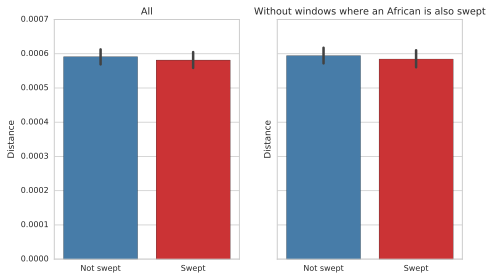

In [18]:
plot_df = (merged_data
#       .loc[lambda df: (df.never_swept == False) & (df.conserv_swept_group != 'ambig')]
      .loc[lambda df: (df.partial_sweep_win_af == True) & (df.conserv_swept_group_af != 'ambig')]
      .groupby(['start', 'end', 'swept_af'])['mean_dist_to_africans_af']
      .mean()
      .to_frame('mean_afr_dist_af')
      .reset_index()
      # removing 'ambig' creates windows that does not have both swept and non-swept
      # so we need to filter to get only windows that include both calls:
      .groupby(['start']).filter(lambda df: set(df['swept_af']) == set([False, True]))
       )

print(plot_df.groupby('swept_af').mean())

swept = plot_df.sort_values(by='start').loc[lambda df: df['swept_af']==True, 'mean_afr_dist_af']
non_swept = plot_df.sort_values(by='start').loc[lambda df: df['swept_af']==False, 'mean_afr_dist_af']
pval = scipy.stats.ttest_rel(swept, non_swept, axis=0, nan_policy='propagate').pvalue
reduction = (non_swept.values-swept.values)/non_swept.values
print()
print(len(swept), '100kb chromosome windows')
print('paired t-test pvalue:', pval)
print('mean reduction of swept:', numpy.mean(reduction))

windows_without_swept_afr = (sweep_data
                             .groupby(['start'])
                             .filter(lambda df: ((df.swept_af == True) & (df.region_1 == 'Africa')).sum() == 0)
                             .loc[:, ['start', 'end']]
                             .drop_duplicates()
                            )

with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.0):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4), sharey=True)

            g1 = sns.barplot(x="swept_af", y="mean_afr_dist_af", 
                             data=plot_df, 
                             ax=ax1, n_boot=1000)
#             ax1.set_title('All data used when evaluating\npairwise differences')
            ax1.set_title('All')
            ax1.set_ylabel('Distance')
            ax1.set_xlabel('')
            ax1.set_xticklabels(['Not swept', 'Swept'])
            
#             ax1.set_xticklabels(['All data used when evaluating\npairwise differences', 'Admixture segments ignored\nwhen evaluating pairwise distances'])


            
            g2 = sns.barplot(x="swept_af", y="mean_afr_dist_af", 
                             data=plot_df.merge(windows_without_swept_afr, on=['start', 'end']),
                             ax=ax2, n_boot=1000)
            ax2.set_title('Without windows where an African is also swept')
            ax2.set_ylabel('Distance')
            ax2.set_xlabel('')
            ax2.set_xticklabels(['Not swept', 'Swept'])
            
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'dist_to_afr_af.pdf' ))
            plt.savefig(str(figures_dir / 'dist_to_afr_af.png' ))

All:
WestEurasia          pvalue: 0.37       corrected pvalue: 2.2        mean reduction: 0.01      
SouthAsia            pvalue: 0.015      corrected pvalue: 0.093      mean reduction: 0.024     
CentralAsiaSiberia   pvalue: 0.0007     corrected pvalue: 0.0042     mean reduction: 0.029     
Oceania              pvalue: 0.00025    corrected pvalue: 0.0015     mean reduction: 0.026     
EastAsia             pvalue: 0.00017    corrected pvalue: 0.001      mean reduction: 0.029     
America              pvalue: 0.14       corrected pvalue: 0.84       mean reduction: 0.019     

Without windows where an African is also swept:
WestEurasia          pvalue: 0.38       corrected pvalue: 2.3        mean reduction: 0.01      
SouthAsia            pvalue: 0.021      corrected pvalue: 0.13       mean reduction: 0.025     
CentralAsiaSiberia   pvalue: 0.00062    corrected pvalue: 0.0037     mean reduction: 0.031     
Oceania              pvalue: 0.00027    corrected pvalue: 0.0016     mean reductio

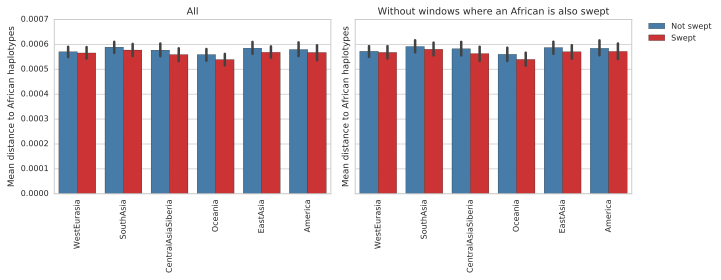

In [23]:
plot_df = (merged_data
      .loc[lambda df: (df.partial_sweep_win_af == True) & (df.conserv_swept_group_af != 'ambig')]
      .groupby(['start', 'end', 'swept_af', 'region_1'])['mean_dist_to_africans_af']
      .mean()
      .to_frame('mean_afr_dist_af')
      .reset_index()
      # removing 'ambig' creates windows that does not have both swept and non-swept
      # so we need to filter to get only windows that include both calls:
      .groupby(['start', 'region_1']).filter(lambda df: set(df['swept_af']) == set([False, True]))
      )

plot_df['region_1'] = plot_df.region_1.cat.remove_unused_categories()

print("All:")
for name, group in plot_df.groupby(['region_1']):
    swept = group.sort_values(by='start').loc[lambda df: df['swept_af']==True, 'mean_afr_dist_af']
    non_swept = group.sort_values(by='start').loc[lambda df: df['swept_af']==False, 'mean_afr_dist_af']
    pval = scipy.stats.ttest_rel(swept, non_swept, axis=0, nan_policy='propagate').pvalue
    mean_reduction = numpy.mean((non_swept.values-swept.values)/non_swept.values)
    print("{:<20} pvalue: {:<10.2} corrected pvalue: {:<10.2} mean reduction: {:<10.2}".format(name, pval, pval*6, mean_reduction))
print()
print("Without windows where an African is also swept:")
for name, group in plot_df.merge(windows_without_swept_afr, on=['start', 'end']).groupby(['region_1']):
    swept = group.sort_values(by='start').loc[lambda df: df['swept_af']==True, 'mean_afr_dist_af']
    non_swept = group.sort_values(by='start').loc[lambda df: df['swept_af']==False, 'mean_afr_dist_af']
    pval = scipy.stats.ttest_rel(swept, non_swept, axis=0, nan_policy='propagate').pvalue
    mean_reduction = numpy.mean((non_swept.values-swept.values)/non_swept.values)
    print("{:<20} pvalue: {:<10.2} corrected pvalue: {:<10.2} mean reduction: {:<10.2}".format(name, pval, pval*6, mean_reduction))
    
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper', font_scale=1.0):
        with sns.axes_style('whitegrid'):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
            g1 = sns.barplot(x="region_1", y="mean_afr_dist_af", hue='swept_af', 
                             data=plot_df, 
                             ax=ax1, n_boot=1000)
            ax1.set_ylabel('Mean distance to African haplotypes')
            ax1.set_xlabel('')
            ax1.set_title('All')
            for item in g1.get_xticklabels():
                item.set_rotation(90)
            ax1.legend_.remove()
            #ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

            g2 = sns.barplot(x="region_1", y="mean_afr_dist_af", hue='swept_af', 
                             data=plot_df.merge(windows_without_swept_afr, on=['start', 'end']),
                             ax=ax2, n_boot=1000)
            ax2.set_ylabel('Mean distance to African haplotypes')
            ax2.set_xlabel('')
            ax2.set_title('Without windows where an African is also swept')
            for item in g2.get_xticklabels():
                item.set_rotation(90)
                
                
            ax2.get_legend().set_title('Is swept')
            handles, labels = ax2.get_legend_handles_labels()

            ax2.legend(handles, ['Not swept', 'Swept'],
                     bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.
                     # bbox_to_anchor=(1., 1.0),  loc='upper left',
                     # bbox_to_anchor=(0., 1.02, 1., .102), loc='upper center', ncol=2
                    )    
                
            plt.tight_layout()
            
            plt.savefig(str(figures_dir / 'dist_to_afr_by_region_af.pdf' ))
            plt.savefig(str(figures_dir / 'dist_to_afr_by_region_af.png' ))

## Maps of Africa with different sized dots for each population


**Note that swept windows share a distance to Africa. Take that into account somehow not to falsely inflate power**

Only windows that are `swept` or `surely_not_swept` the plotting data frame:


**Try this too:**
- Partion using the subset approach. Hope to see the same pattern.
- For the subset approach also plot dist to the afr indiv that each non-afr is closest to. Would be nice to see that swept and non-swept.

Since Africa is not panmictic it is not possible to get relative OaA datas by normalizing with mean population Ne.
All I can do is show that swept and non-swept come from different places and/or show different divergence.

Load population center locations:

In [20]:
pop_locations = pickle.load(open(str(results_dir / 'pop_locations.pkl'), 'rb'))

Extract pair or pairs for each window, where difference is minimal:

In [21]:
#df = pwdiff_store.select('df', '(region_label_1 != "Africa") & (region_label_2 == "Africa")')

In [22]:
def only_min_dist_rows(df):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        min_dist = numpy.nanmin(df.dist)
    return (df
            .loc[df.dist == min_dist, ['pop_2']] # rows where min_dist is nan are not included
            .drop_duplicates()
            .assign(pop_2_contrib = lambda x: len(x) and 1 / x.pop_2.unique().size or 0)
            # maybe add:
            # .assign(min_dist_to_afr = min_dist)
           )

# only_nonafr_afr = (df
#       .groupby(['indiv_1', 'start'])
#       .apply(only_min_dist_rows)
#       .reset_index(level=['indiv_1', 'start'])
#      ).merge(sweep_data[['indiv_1', 'start', 'swept', 'run_length']],
#              on=['indiv_1', 'start'],
#              how='left'
#             )

df = (nonafr_afr_subset
      .groupby(['indiv_1', 'start'])
      .apply(only_min_dist_rows)
      .reset_index(level=['indiv_1', 'start'])
     )

KeyboardInterrupt: 

In [ ]:
merged_min_dist_data =  (df.merge(sweep_data[['indiv_1', 'start', 
                                      'swept', 'swept_af', 
                                      'never_win_swept', 'never_win_swept_af',
                                      'conserv_swept_group', 'conserv_swept_group_af',
                                      'run_length']],
                          on=['indiv_1', 'start'],
                          how='left')
                   .loc[lambda df: (df.never_win_swept == False) & (df.conserv_swept_group != 'ambig')]
                  )

Function for plotting the maps:

In [ ]:
def plot_map(areas, longs, lats, names, colors, ax):
    m = Basemap(projection='mill',
                urcrnrlon=60, 
                urcrnrlat=40,
                llcrnrlon=-20,
                llcrnrlat=-40,
                resolution='c', # 'c' is crude, l is low, i is intermediate, h is high, f is full
                suppress_ticks=True, ax=ax)
    m.fillcontinents(color='lightgrey',lake_color='white', zorder=0)
    m.drawcountries(linewidth=0.2, linestyle='solid', color='black', zorder=1)

    x, y = zip(*[m(lat, long) for lat, long in zip(lats, longs)])
    
    scatter = m.scatter(x, y, s=areas, alpha=0.5, c=colors)
#     scatter = m.scatter(x, y, s=areas, alpha=0.5, c='#377eb8')
    m.scatter(x, y, s=10, c='black')
    
    for i, n in enumerate(names):
        ax.annotate(str(i+1), (x[i], y[i]))
    print(*["{}: {}".format(i+1, n) for i, n in enumerate(names)], sep=', ')
    
    return scatter


def draw_constrasting_maps(pop_2_contributions):
#     plt.close()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

    swept_subset = pop_2_contributions.loc[pop_2_contributions.swept]
    not_swept_subset = pop_2_contributions.loc[~pop_2_contributions.swept]

    
    scale = 100 / not_swept_subset.pop_2_contrib.sum() # for appropriate marker size
    names = list(not_swept_subset.pop_2)

    areas = numpy.pi * (scale * not_swept_subset.pop_2_contrib )**2
#     areas = [scale * math.sqrt(x/numpy.pi) for x in not_swept_subset.pop_2_contrib]

    coords = [pop_locations[n] for n in  not_swept_subset.pop_2]
    longs, lats = zip(*coords)

    #ax1.set_title('Not swept')
    ax1.set_xlabel('Not swept')
    scatter1 = plot_map(areas, longs, lats, names, set1['blue'], ax1)

    tooltip1 = mpld3.plugins.PointLabelTooltip(scatter1, labels=names)
    mpld3.plugins.connect(fig, tooltip1)
        
    
    scale = 100 / swept_subset.pop_2_contrib.sum()
    names = list(swept_subset.pop_2)

    areas = numpy.pi * (scale * swept_subset.pop_2_contrib )**2
#     areas = [scale * math.sqrt(x/numpy.pi) for x in swept_subset.pop_2_contrib]

    coords = [pop_locations[n] for n in  swept_subset.pop_2]
    longs, lats = zip(*coords)

    #ax2.set_title('Swept')
    ax2.set_xlabel('Swept')
    scatter2 = plot_map(areas, longs, lats, names,  set1['blue'], ax2)

    tooltip2 = mpld3.plugins.PointLabelTooltip(scatter2, labels=names)
    mpld3.plugins.connect(fig, tooltip2)
    
    plt.tight_layout()

    return fig

### Only haplotype windows that are either swept or surely_not_swept

### Only windows that are swept in at least some individuals

In [ ]:
def pop_contrib(df):
    pop_contr = (df
#                        .groupby(['start'])
#                        .filter(lambda df: df.swept.sum() > 0)                        
                       .loc[lambda df: (df.never_win_swept == False) & (df.conserv_swept_group != 'ambig'),
                           ['pop_2', 'swept', 'pop_2_contrib']]
#                       .loc[:, ['pop_2', 'swept', 'pop_2_contrib']]
                       .groupby(['pop_2', 'swept'])
                       .sum()
                       .reset_index()
                      )  
    pop_contr.set_index('swept', inplace=True)
    pop_contr['total'] = pop_contr.groupby(['swept'])['pop_2_contrib'].sum()
    pop_contr.reset_index(inplace=True)
    pop_contr['pop_2_contrib_fract'] = pop_contr.pop_2_contrib / pop_contr.total
    return pop_contr

pop_2_contributions = pop_contrib(merged_min_dist_data)

#pop_2_contributions.head()

In [ ]:
pop_2_contributions.pivot(index='pop_2', columns='swept', values='pop_2_contrib')

In [ ]:
fig = draw_constrasting_maps(pop_2_contributions)
plt.suptitle('1: BantuHerero, 2: BantuKenya, 3: BantuTswana, 4: Biaka, 5: Dinka, 6: Esan,\n7: Gambian, 8: Ju_hoan_North, 9: Luhya, 10: Luo, 11: Mandenka, 12: Mbuti, 13: Mende, 14: Yoruba')
plt.tight_layout()
plt.savefig(str(figures_dir / 'afr_map_pair.pdf'))

In [ ]:
mpld3.display(fig)

In [ ]:
# blocked jackknife
merged_min_dist_data['block_label'] = merged_min_dist_data.start // 5e5
pseudo_list = list()
                      
block_labels = merged_min_dist_data.block_label.unique()
                      
for block_label in block_labels:
    one_left_out = merged_min_dist_data.loc[lambda df: df.block_label != block_label]
    
    df = pop_contrib(one_left_out)
        
    df.pop_2_contrib_fract = len(block_labels) * pop_2_contributions.pop_2_contrib_fract \
                      - (len(block_labels) - 1) * df.pop_2_contrib_fract

    df = df.drop(['total', 'pop_2_contrib'], axis=1)
     
    pseudo_list.append(df)

import scipy

def conf_int(sr):
    return scipy.stats.t.ppf(0.975, len(block_labels)-1) * numpy.sqrt(sr.var() / sr.size)

df = (pandas.concat(pseudo_list)
      .groupby(['pop_2', 'swept'])
      .aggregate(conf_int)
      .rename(columns={'pop_2_contrib_fract': 'ci'})
      .reset_index()
     )

#df.head()

plot_df = pop_2_contributions.merge(df, on=['pop_2', 'swept'], how='left')
plot_df.head()

In [ ]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            fig, ax = plt.subplots(1, 1, figsize=(8, 5))

            g = sns.barplot(x='pop_2_contrib_fract', y='pop_2', 
                            hue='swept', ci='ci', data=plot_df, ax=ax)
            
            ci_list = list(plot_df.ci[0:][::2]) + list(plot_df.ci[1:][::2])
#            print(ci_list)
            for p, ci in zip(g.patches, ci_list):                
                h = p.get_height()
                x, y = p.get_width(), p.get_y()
#                print(x, y)
#                 ci = plot_df.loc[lambda df: df.pop_2_contrib_fract == x].ci
# #                ci = plot_df.loc[lambda df: numpy.isclose(df.pop_2_contrib_fract, x, atol=0.01)].ci
#                 assert len(ci) == 1, (ci, x)
#                 ci = ci[0]
                g.add_line(Line2D([x-ci, x+ci], [y+h/2, y+h/2], color='black'))
            g.set_xlim(0, 0.35)

In [ ]:
with sns.color_palette([set1['blue'], set1['red']]):
    with sns.plotting_context('paper'):
        with sns.axes_style('whitegrid'):
            g = sns.barplot(x='pop_2_contrib_fract', y='pop_2', hue='swept', data=pop_2_contributions)

In [ ]:

# bootstrap <- function(x, n, f, ...) replicate(n, f(sample(x, replace=TRUE), ...))
# bootstrap_lower <- function(x, n, f, ...) f(x, ...) - qt(0.975,n-1) * sd(bootstrap(x, n, f, ...))
# bootstrap_upper <- function(x, n, f, ...) f(x, ...) + qt(0.975,n-1) * sd(bootstrap(x, n, f, ...))

# jackknife_moving_block <- function(x, m, f, ...) {
#   n = length(x)
#   pseudo <- numeric(n-m+1)
#   for (i in 1:(n-m+1)) {
#     pseudo[i] <- (n * f(x, ...) - (n-m) * f(x[-(i:(i+m-1))], ...)) / m
#     }
#   return(pseudo)
# }
# moving_jackknife_upper <- function(x, m, f, ...) {
#   pseudo <- jackknife_moving_block(x, m, f, ...)
#   n <- length(x)
#   b = n %/% m
#   est_var <- var(pseudo) / b
#   return(mean(pseudo) + qt(0.975,b-1) * sqrt(est_var))
# }
# moving_jackknife_lower <- function(x, m, f, ...) {
#   pseudo <- jackknife_moving_block(x, m, f, ...)
#   n <- length(x)
#   b = n %/% m
#   est_var <- var(pseudo) / b
#   return(mean(pseudo) - qt(0.975,b-1) * sqrt(est_var))
# }

# jackknife <- function(x, m, f, ...) {
#   n = length(x)
#   b = n %/% m # blocks
#   pseudo <- numeric(b)
#   for (i in 1:b) {
#     s <- (i-1)*m+1
#     e <- i*m
#     pseudo[i] <- b * f(x, ...) - (b-1) * f(x[-(s:e)], ...)
# }
#   return(pseudo)
# }
# jackknife_upper <- function(x, m, f, ...) {
#   pseudo <- jackknife(x, m, f, ...)
#   n <- length(x)
#   b = n %/% m
#   est_var <- var(pseudo) / b
#   return(mean(pseudo) + qt(0.975,b-1) * sqrt(est_var))
# }
# jackknife_lower <- function(x, m, f, ...) {
#   pseudo <- jackknife(x, m, f, ...)
#   n <- length(x)
#   b = n %/% m
#   est_var <- var(pseudo) / b
#   return(mean(pseudo) - qt(0.975,b-1) * sqrt(est_var))
# }

# vanilla_jackknife <- function(x, f, ...) {
#   n <- length(x)
#   pseudo <- numeric(n)
#   for (i in 1:n) {
#     pseudo[i] <- n * f(x, ...) - (n-1) * f(x[-i], ...)
#   }
#   return(pseudo)
#   }
# vanilla_jackknife_upper <- function(x, f, ...) {
#   pseudo <- vanilla_jackknife(x, f, ...)
#   return(mean(pseudo) + qt(0.975,length(x)-1)*sqrt(var(pseudo)/length(x)))
# }
# vanilla_jackknife_lower <- function(x, f, ...) {
#   pseudo <- vanilla_jackknife(x, f, ...)
#   return(mean(pseudo) - qt(0.975,length(x)-1)*sqrt(var(pseudo)/length(x)))
# }




## Plot difference between window subsets for better visualization

In [ ]:
swept_subset = pop_2_contributions.loc[pop_2_contributions.swept == True]
not_swept_subset = pop_2_contributions.loc[pop_2_contributions.swept == False]

df = swept_subset.set_index('pop_2').pop_2_contrib / swept_subset.pop_2_contrib.sum() \
    - not_swept_subset.set_index('pop_2').pop_2_contrib / not_swept_subset.pop_2_contrib.sum()
df = df.reset_index()
df

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

scale = 2000
names = list(not_swept_subset.pop_2)

#areas = numpy.sign(df.pop_2_contrib) * numpy.pi * (scale * df.pop_2_contrib )**2
areas = numpy.sign(df.pop_2_contrib) * [scale * math.sqrt(abs(x/numpy.pi)) for x in df.pop_2_contrib]

coords = [pop_locations[n] for n in  not_swept_subset.pop_2]
longs, lats = zip(*coords)

colors = [x > 0 and set1['blue'] or set1['red'] for x in areas]
areas = numpy.absolute(areas)

scatter = plot_map(areas, longs, lats, names, colors, ax)

tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=names)
mpld3.plugins.connect(fig, tooltip)

plt.tight_layout()

ax.set_title('Swept - not swept')

#plt.show()
mpld3.display(fig) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

#data
x = [1, 2, 2]
y = [3, 2.5, 3]
ysize = [7000, 3500, 3500]
    
ysize = [math.sqrt(x/numpy.pi) for x in ysize]
    
# * (scale * swept_subset.pop_2_contrib )**2
    
for i in range (0, len(x)):
    plt.plot(x[i], y[i], linestyle="None", marker="o", markersize=ysize[i], color="red")
    
plt.plot(x, y, linestyle="dotted", color="red")


plt.xlim(np.min(x)-1.3, np.max(x)+1.3) #optional 
plt.ylim(np.min(y)-1.3, np.max(y)+1.3) #optional 

plt.xlabel("random y")
plt.ylabel("random x")

plt.show()

## Which peaks include Africans?

In [ ]:
sweep_peaks = pandas.read_hdf(results_dir / 'sweep_peaks.hdf')
sweep_peaks.head()

In [ ]:
records = list()
for tup in sweep_peaks.itertuples():
    afr_indivs = sweep_data.loc[lambda df: (df.start >= tup.start) & (df.end <= tup.end) & \
                      (df.swept == True) & (df.region_1 == 'Africa'), 'indiv_1'].unique()
    records.append((tup.start, tup.end, afr_indivs))
df = (sweep_peaks
      .merge(DataFrame()
             .from_records(records, columns=['start', 'end', 'arf_indivs']),
                  on=['start', 'end'],
                  how='left')
      .sort_values(by=['prop_swept'], ascending=False)
     )


In [ ]:
argweaver_tmrca_100kb = pandas.read_hdf(results_dir / 'argweaver_tmrca_100kb.hdf')

In [ ]:
def argweaver_gen_to_years(sr):
    return sr * 25 * 1.5e-8/1.8e-8

argweaver_tmrca_100kb_years = (argweaver_tmrca_100kb
#                                .groupby(['peak_pos', 'chain', 'file_start', 'file_end'])[['sweep_tmrca', 'tmrca']]
                               .groupby(['peak_pos'])[['sweep_tmrca', 'tmrca']]
                               .mean()
                               .transform(argweaver_gen_to_years)
                               .reset_index()
                              )
argweaver_tmrca_100kb_years.head()

In [ ]:
df.merge(argweaver_tmrca_100kb_years, 
         left_on=['pos'], 
         right_on=['peak_pos'], how='left')[['peak_pos', 'prop_swept', 'arf_indivs', 'sweep_tmrca', 'tmrca']]

In [ ]:
# df2 = df.merge(argweaver_tmrca_100kb_years, 
#          left_on=['pos'], 
#          right_on=['peak_pos'], how='left')[['peak_pos', 'prop_swept', 'arf_indivs', 'sweep_tmrca', 'tmrca']]
# s = set(    ['Masai', 'Somali', # show some non-African component in Structure plot in main paper (Laurits does that too)
#                  'Mozabite', 'Saharawi'] # known non-african ancestry and Neanderthal admxiture
#        )
# for tup in df2.itertuples():
#     s.update(tup.arf_indivs)
    
# print(s)

In [ ]:
# # pandas.read_hdf(results_dir / 'sweep_peaks.hdf').to_csv(results_dir / 'sweep_peaks.csv')

# def foo(df, nr_wins):
#     if len(df) == nr_wins:
#         return numpy.array([True] * len(df))
#     else:
#         return numpy.array([numpy.nan] * len(df))

# offsets = [0, 100000, 300000, 300000, 400000] 
# window_size = 500000
# df = pandas.DataFrame({'B': numpy.array(range(10))*100000})
# lst = list()
# for off in offsets:
#     result = df.assign(window = (off + df.B) // window_size).groupby('window').apply(foo, window_size / 100000)
#     fl = [x for y in result for x in y]
#     lst.append(fl)
# print(list(map(any, numpy.array(lst).transpose())))
# # lst


